In [2]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.density import LogDensityGeneral
from mcjax.mcmc.rwm import Rwm
from mcjax.util.mcmc import ESS_geyer, ESS_AR1, normalized_autocorr



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# initialize jax RNG
key = jr.key(0)

### Target concentratin in the neighbourhood of a sub-manifold


In [4]:
def sine_logpdf(_x):
    """
    the target concentrates in a neighborhood of the curve y = sin(5x)
    """
    x, y = _x[0], _x[1]
    SIGMA_X = 2.
    NOISE_STD = 0.2
    return -0.5*( (x/SIGMA_X)**2 + ((y - jnp.sin(5*x))/NOISE_STD)**2 )

dist = LogDensityGeneral(logdensity=sine_logpdf, dim=2)

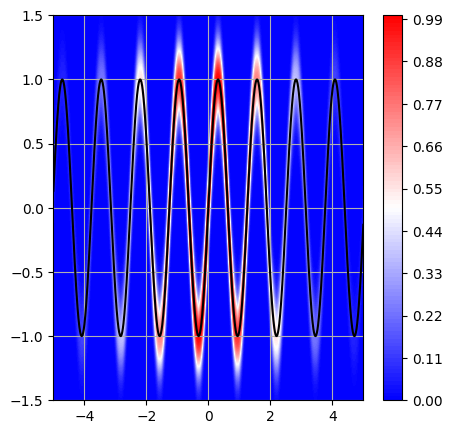

In [5]:
xmin, xmax = -5, 5
ymin, ymax = -1.5, 1.5
N_discr = 500
X, Y = np.meshgrid(np.linspace(xmin, xmax, N_discr), np.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_flat = dist.batch(jnp.array([X_flat, Y_flat]).T)
Z = Z_flat.reshape(X.shape)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.grid()

# plt the curve y = sin(5x)
x = np.linspace(xmin, xmax, 1000)
plt.plot(x, np.sin(5*x), 'k-')

### Run RWM

In [6]:
# random walk metropolis
mcmc = Rwm(logtarget=dist, step_size=0.1, cov=jnp.eye(2))

# initial state
x_init = jnp.array([0., 0.])
state_init = mcmc.init_state(x_init)

# run the chain
n_samples = 10_000
key, key_ = jr.split(key)
mcmc_output = mcmc.run(key=key_, state_init=state_init, n_samples=n_samples)

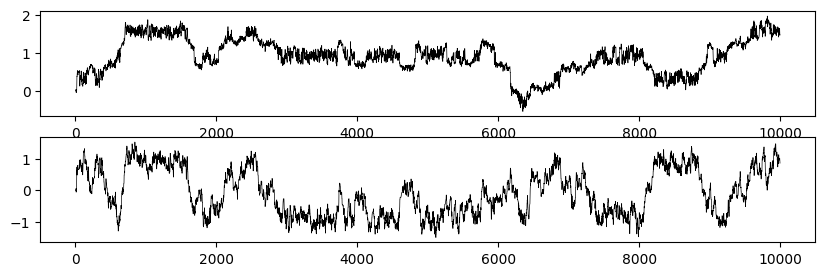

In [7]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(mcmc_output["x"][:, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(mcmc_output["x"][:, 1], color='black', lw=0.5)

### Influence of the step size

In [10]:
# let's define a function that samples a trajectory -- small wrapper around the `sample_RWM` function
def sample_RWM(key, x0, step_size, n_steps):
    # define the RWM sampler
    mcmc = Rwm(logtarget=dist, step_size=step_size, cov=jnp.eye(2))
    # sample the trajectory
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_RWM = jax.jit(sample_RWM, static_argnums=(3,))

# let's define a function that samples a batch of trajectories
# for different step sizes so that we can study the influence of the step size
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(None, None, 0, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3,))


In [11]:
x0 = jnp.array([0., 0.])
step_size = 0.1
n_steps = 1000_000
key, key_ = jr.split(key)
mcmc_output = sample_RWM(key_, x0, step_size, n_steps)

In [12]:
step_size_arr = np.linspace(0.01, 5., 500)
n_steps = 100_000
mcmc_output_batch = sample_RWM_batch(key, x0, step_size_arr, n_steps)


Text(0.6, 0.6, 'Optimal step size: 2.13 \n Acceptance rate: 0.09')

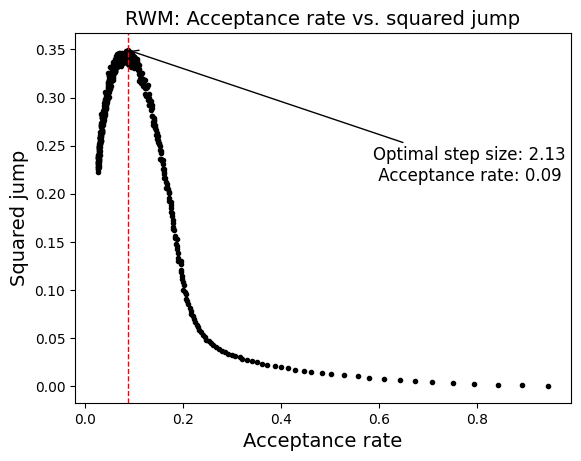

In [13]:
plt.plot(mcmc_output_batch["acceptance_rate"], mcmc_output_batch["sq_jump"], ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("RWM: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(mcmc_output_batch["sq_jump"])
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = mcmc_output_batch["acceptance_rate"][index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, mcmc_output_batch["sq_jump"][index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)

In [21]:
# now, let's tune by maximizing the effective sample size
#ess_geyer_list = [ESS_geyer(mcmc_output_batch["x"][k,:,0]) for k in range(len(step_size_arr))]
ess_list = [ESS_AR1(mcmc_output_batch["x"][k,:,0]) for k in range(len(step_size_arr))]

Text(0.5, 1.0, 'RWM: Acceptance rate vs. ESS (Geyer)')

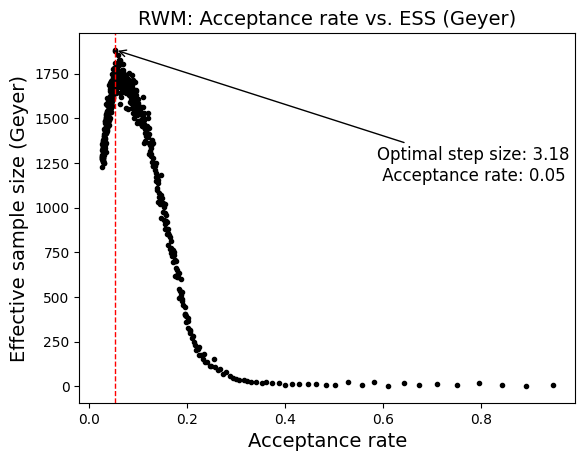

In [22]:
plt.plot(mcmc_output_batch["acceptance_rate"], ess_list, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Effective sample size (Geyer)", fontsize=14)

# find the optimal step size by maximizing the ESS
index_opt = np.argmax(ess_list)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = mcmc_output_batch["acceptance_rate"][index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, ess_list[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.title("RWM: Acceptance rate vs. ESS (Geyer)", fontsize=14)

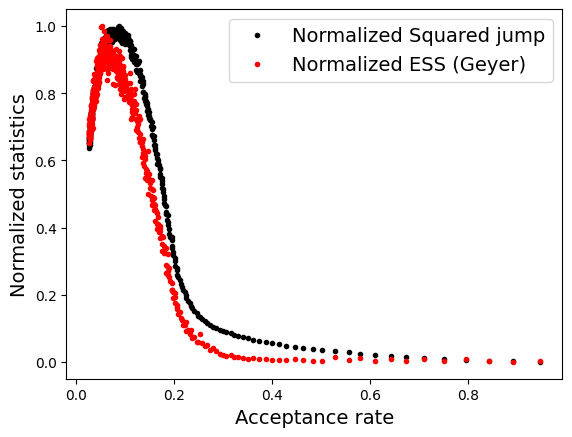

In [24]:
# compare ESS vs squared jump statistics
max_sq_jump = np.max(mcmc_output_batch["sq_jump"])
plt.plot(mcmc_output_batch["acceptance_rate"], mcmc_output_batch["sq_jump"]/max_sq_jump, ".", color='black', label="Normalized Squared jump")
max_ess_geyer = np.max(ess_list)
plt.plot(mcmc_output_batch["acceptance_rate"], ess_list/max_ess_geyer, ".", color='red', label="Normalized ESS (Geyer)")
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Normalized statistics", fontsize=14)
plt.legend(fontsize=14)


Text(0.5, 1.0, 'RWM: Autocorrelation function')

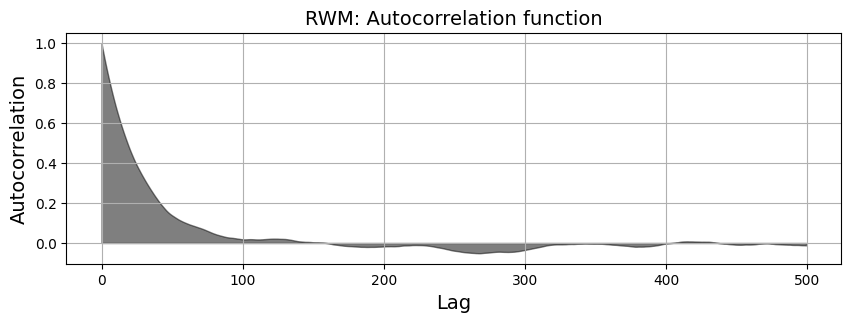

In [25]:
# plot the autocorrelation function at the optimal step size
# trajectory = mcmc_output_batch["x"][0, :, 0]
trajectory = mcmc_output_batch["x"][index_opt, :, 0]
autocorr = normalized_autocorr(trajectory)

# plot with fill_between
plt.figure(figsize=(10, 3))
max_lag = 500
plt.fill_between(np.arange(max_lag), [0 for _ in range(max_lag)], autocorr[:max_lag], color='black', alpha=0.5)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.grid()
plt.title("RWM: Autocorrelation function", fontsize=14)

In [18]:
# run a chain with the optimal step size
key, key_ = jr.split(key)
n_samples = 1_000_000
mcmc_output_opt = sample_RWM(key_, x0, optimal_step_size, n_steps)

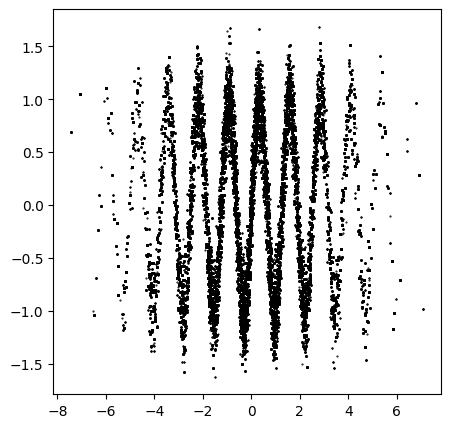

In [28]:
# scatter plot of the samples
plt.figure(figsize=(5, 5))
plt.scatter(mcmc_output_opt["x"][:, 0], mcmc_output_opt["x"][:, 1], s=1, color='black', marker='.')

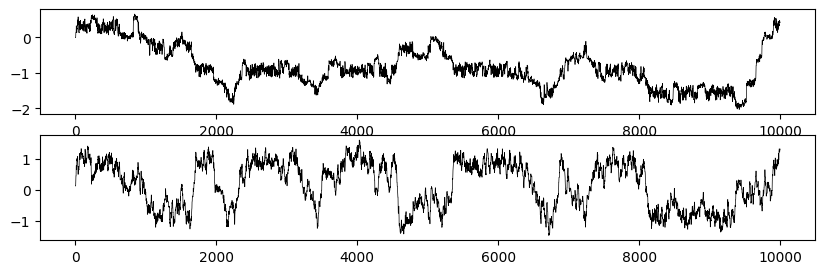

In [29]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(mcmc_output["x"][:10000, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(mcmc_output["x"][:10000, 1], color='black', lw=0.5)